In [6]:
import xarray as xr
import dask
import numpy as np
from datetime import datetime, timedelta
from cartopy.feature.nightshade import Nightshade
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os, glob, sys, gc
from tqdm.auto import tqdm
import pandas as pd

/glade/work/abukowski/conda-envs/SAMI3-GITM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import argparse
import glob
import os
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import xarray as xr

import importlib

import warnings

In [8]:
import utility_programs.filters as filters
from utility_programs.plotting_routines import panel_plot
from utility_programs.read_routines.GITM import auto_read as auto_read_gitm
from utility_programs.read_routines.GITM import gitm_times_from_filelist
from utility_programs.read_routines.SAMI import auto_read as auto_read_sami
from utility_programs import plotting_routines
from utility_programs.utils import ut_to_lt
from utility_programs.utils import add_lt_to_dataset

/glade/u/home/abukowski/Documents/CEDAR2023/utility_programs/plotting_routines.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


In [9]:
data = '/glade/u/home/abukowski/scratch/postprocessed/'

In [10]:
gitms = {}
samis = {}

for full_path in np.sort(glob.glob(os.path.join(data,'*.nc'))):

    fname = full_path[full_path.rfind('/')+1:]
    datas = fname[:-3].split('_')
    month = datas[0]

    if 'bz' in datas[1]:
        if 'SAMI' in datas:
            model = datas[-2] + '-'+datas[-1]
        else:
            model = datas[-1]
        month = datas[0]
        runname = datas[1][5:]
        onset = datas[2]
        duration = datas[3]

    elif 'thm' not in datas:
        if 'SAMI' in datas:
            model = datas[-2] + '-'+datas[-1]
        else:
            model = datas[-1]
        month = datas[0]
        runname = datas[1]
        onset = datas[2]
        duration = datas[3]
        
    else:
        continue

    if model == 'GITM':
        gitms['-'.join([month, onset, duration, runname])] = xr.open_mfdataset(full_path, engine='h5netcdf')

    elif model == 'SAMI-REGRID':
        samis['-'.join([month, onset, duration, runname])] = xr.open_mfdataset(full_path, engine='h5netcdf')


In [11]:
# Preprocess


## Time slicing
t_starts = {'ut6':'03:00:00', 'ut12':'09:00:00', 'ut18':'15:00:00'}

for k in gitms.keys():
    key = k.split('-')[1]
    t_start = gitms[k].time.values[0] + pd.Timedelta('1 day' + t_starts[key])
    t_end = t_start + pd.Timedelta('8 hours')
    
    gitms[k] = gitms[k].sel(time = slice(t_start, t_end))
    
for k in samis.keys():
    key = k.split('-')[1]
    t_start = samis[k].time.values[0] + pd.Timedelta('1 day' + t_starts[key])
    t_end = t_start + pd.Timedelta('8 hours')
    samis[k] = samis[k].sel(time = slice(t_start, t_end))    


In [7]:


for k in samis.keys():
    if k in gitms.keys():
        print(k, samis[k].sizes, gitms[k].sizes)

may-ut12-storm-on-full Frozen({'time': 97, 'alt': 40, 'lat': 180, 'lon': 90}) Frozen({'time': 96, 'lon': 90, 'lat': 180, 'alt': 50})
may-ut18-storm-on-full Frozen({'time': 97, 'lat': 90, 'lon': 72, 'alt': 40}) Frozen({'time': 96, 'lon': 90, 'lat': 180, 'alt': 50})
may-ut6-storm-on-full Frozen({'time': 97, 'lat': 90, 'lon': 72, 'alt': 40}) Frozen({'time': 96, 'lon': 90, 'lat': 180, 'alt': 50})
may-ut12-storm-on-half Frozen({'time': 97, 'lat': 90, 'lon': 72, 'alt': 40}) Frozen({'time': 96, 'lon': 90, 'lat': 180, 'alt': 50})
may-ut12-storm-on-quarter Frozen({'time': 97, 'lat': 90, 'lon': 72, 'alt': 40}) Frozen({'lon': 90, 'lat': 180, 'alt': 50, 'time': 192})
nov-ut12-storm-on-full Frozen({'time': 97, 'lat': 90, 'lon': 72, 'alt': 40}) Frozen({'time': 96, 'lon': 90, 'lat': 180, 'alt': 50})
nov-ut18-storm-on-full Frozen({'time': 97, 'lat': 90, 'lon': 72, 'alt': 40}) Frozen({'time': 96, 'lon': 90, 'lat': 180, 'alt': 50})
nov-ut6-storm-on-full Frozen({'time': 97, 'lat': 90, 'lon': 72, 'alt': 4

In [71]:
all_data = {}

for k in samis.keys():
    if k in gitms.keys():
        ds = xr.Dataset()
        for v in gitms[k].data_vars:
            ds['gitm_' +v] = gitms[k][v]
        for v in samis[k].data_vars:
            ds['sami_' +v] = samis[k][v].interp_like(gitms[k].Temperature)
        all_data[k] = ds.copy()
        # del ds
        # del ds
    break

In [88]:
def interp_sami_like_gitm(sami, gitm):
    return sami.interp_like(gitm, method='cubic')

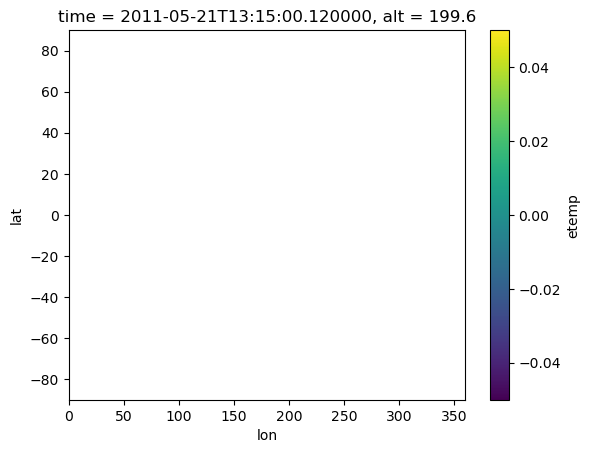

In [92]:
filters.filter_xarray_DA_diff(interp_sami_like_gitm(samis['may-ut12-storm-on-full'],
                                                   gitms['may-ut12-storm-on-full']).etemp.sel(alt=200, method='nearest')).compute().isel(time=50).plot(x='lon')

AttributeError: 'QuadMesh' object has no attribute 'compute'

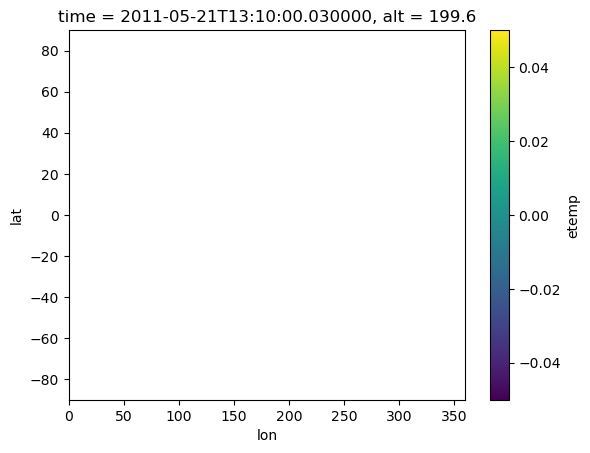

In [93]:
interp_sami_like_gitm(samis['may-ut12-storm-on-full'],
                                                   gitms['may-ut12-storm-on-full']).etemp.sel(
    alt=200, 
    method='nearest').isel(time=50).plot(x='lon').compute()

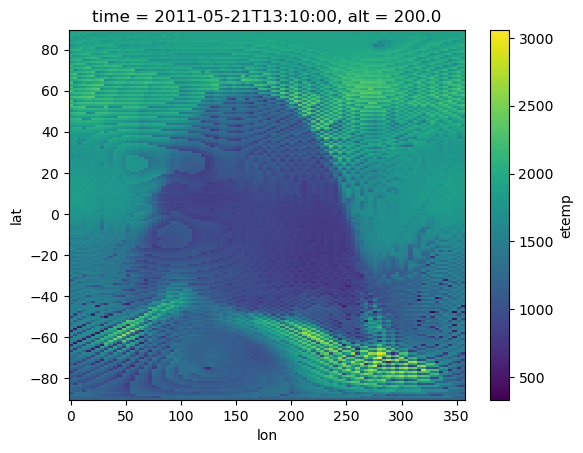

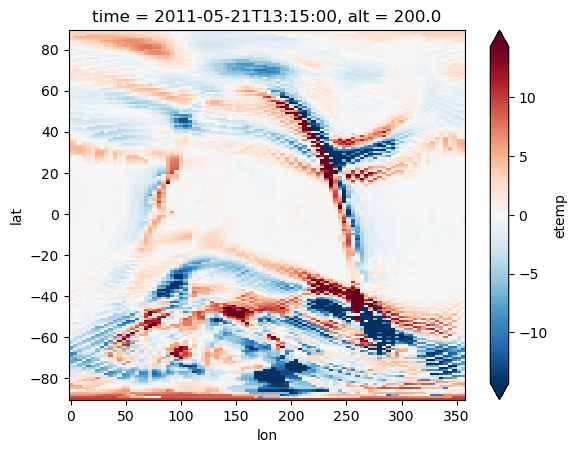

In [99]:
samis['may-ut12-storm-on-full'].etemp.sel(
    alt=200, 
    method='nearest').isel(time=50).plot(x='lon')
plt.show()

filters.filter_xarray_DA_diff(samis['may-ut12-storm-on-full'].etemp.sel(
    alt=200, 
    method='nearest'), order=2).isel(time=50).plot(x='lon', robust=True)

In [102]:
'RAW' in os.walk('/glade/u/home/abukowski/scratch/')

False

In [1]:
from utility_programs.read_routines import SAMI
from scipy import interpolate
from datetime import datetime
import numpy as np
import gc

In [63]:
raws = SAMI.read_raw_to_xarray('/glade/u/home/abukowski/scratch/simstorm-20111121/Full/sami-gitm-coupled/',
                               datetime(2011,11,20), cols='edens')


In [64]:
raws2 = raws.where(raws.alt < 30000).dropna(how='any', dim='nf')

In [65]:
raws2.glat.max(), raws2.glat.min()

(<xarray.DataArray 'glat' ()>
 array(69.39, dtype=float32),
 <xarray.DataArray 'glat' ()>
 array(-79.25, dtype=float32))

In [91]:
X, Y, Z = np.meshgrid(gitms['nov-ut12-storm-on-full'].lat.values, gitms['nov-ut12-storm-on-full'].lon.values, gitms['nov-ut12-storm-on-full'].alt.values)

In [25]:
X.shape

(90, 180, 50)

In [66]:
gc.collect()

16

In [67]:
len(raws.isel(time=15).edens.values.flatten()), len(raws.isel(time=15).glat.values.flatten())

(1474560, 1474560)

In [90]:
raws2.dims

Frozen({'time': 624, 'nlt': 80, 'nf': 62, 'nz': 256})

In [129]:
regridded = interpolate.griddata(
    np.array([raws2.isel(time=50).glat.values.flatten(), raws2.isel(time=50).glon.values.flatten(), raws2.isel(time=50).alt.values.flatten()]).T,
    xi=np.array([X.flatten(), Y.flatten(), Z.flatten()]).T,
    values = raws2.isel(time=50).edens.values.flatten(),
    method='linear', rescale=True)

In [130]:
type(regridded)

numpy.ndarray

In [131]:
regridded.shape

(810000,)

In [132]:
gitms['may-ut12-storm-1hr-full'].sizes

Frozen({'time': 96, 'lon': 90, 'lat': 180, 'alt': 50})

In [133]:
sedens = xr.Dataset({'edens':(('lon','lat','alt'), regridded.reshape(90,180,50))},
                   {'lat':(gitms['nov-ut12-storm-on-full'].lat),
                    'lon':(gitms['nov-ut12-storm-on-full'].lon),
                    'alt':(gitms['nov-ut12-storm-on-full'].alt),})#.reindex_like(gitms['nov-ut12-storm-on-full'])

In [134]:
sedens

<xarray.Dataset>
Dimensions:  (lon: 90, lat: 180, alt: 50)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 2.0 6.0 10.0 14.0 18.0 ... 346.0 350.0 354.0 358.0
  * alt      (alt) float64 100.0 101.7 103.5 105.3 ... 688.9 711.3 733.9 756.6
Data variables:
    edens    (lon, lat, alt) float64 nan nan nan nan nan ... nan nan nan nan nan

(100.0, 750.0)

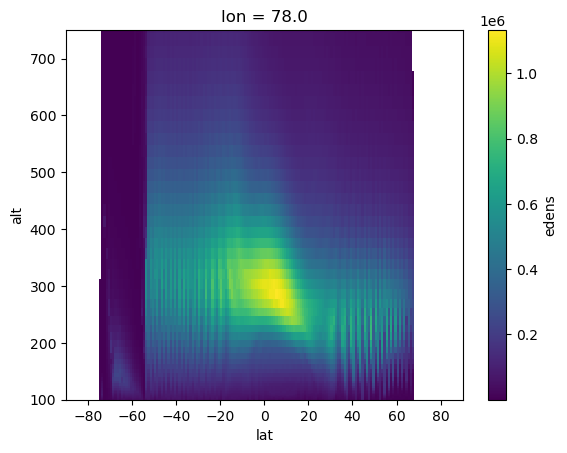

In [135]:
sedens.sel(lon=80, method='nearest').edens.plot(x='lat')
plt.ylim(100,750)

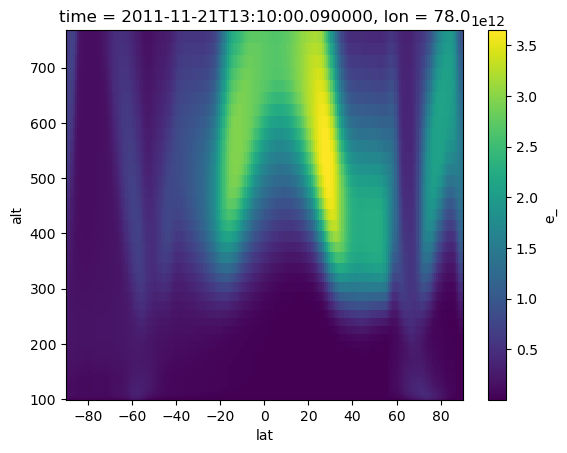

In [107]:
gitms['nov-ut12-storm-on-full'].sel(lon=80, method='nearest').isel(time=50).e_.plot(x='lat')

  0%|          | 0/14 [00:09<?, ?it/s]


AttributeError: 'QuadMesh' object has no attribute 'compute'

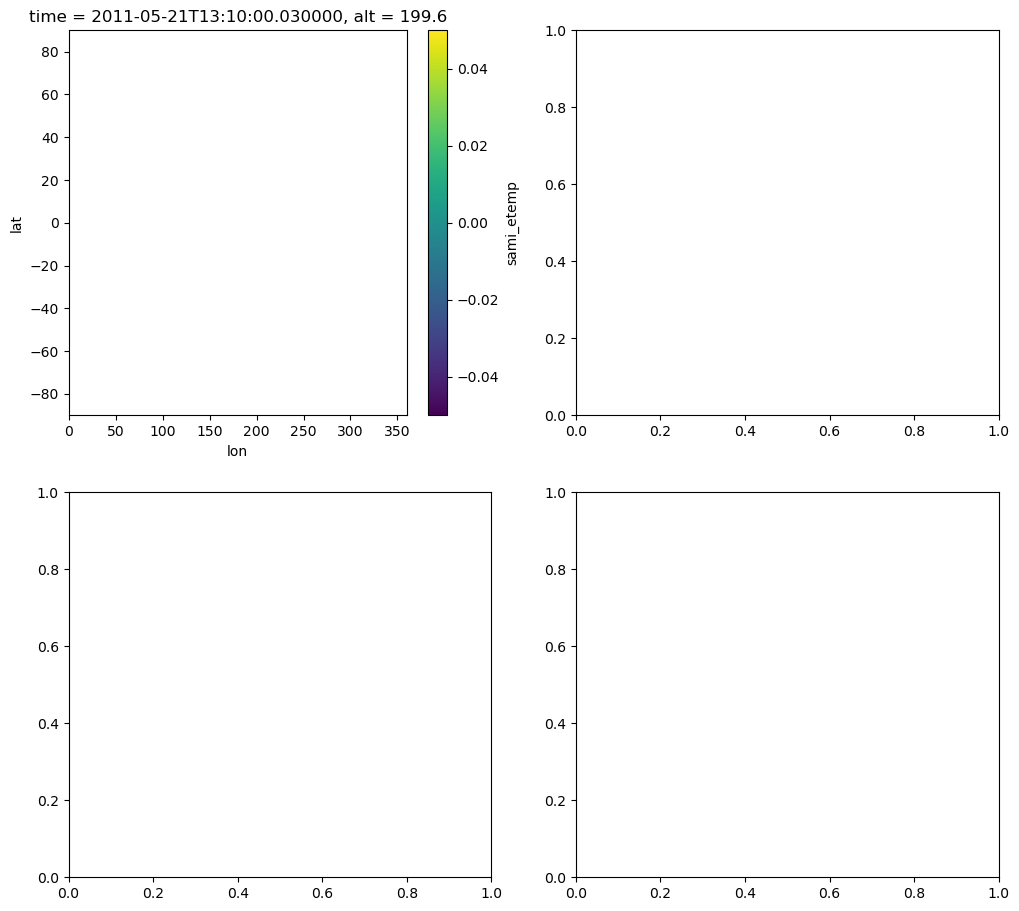

In [61]:
figs = []
for run, ds in tqdm(all_data.items()):
    f, axs = plt.subplots(2, 2, figsize=(12,11))
    
    ds.sami_etemp.sel(alt=200, method='nearest').isel(time=50).plot(x='lon', ax=axs[0,0])
    filters.filter_xarray_DA_diff(ds.sami_etemp.sel(alt=200, method='nearest')).isel(time=50).plot(x='lon', ax=axs[0,1], robust=True)
    
    ds.gitm_eTemperature.sel(alt=200, method='nearest').isel(time=50).plot(x='lon', ax=axs[1,0])
    filters.filter_xarray_DA_diff(ds.gitm_eTemperature.sel(alt=200, method='nearest')).isel(time=50).plot(x='lon', ax=axs[1,1], robust=True)
    
    f.suptitle(run)
    
    # figs.append(f)
    # # plt.close()
    break

In [53]:
for a in figs:
    a.show()
    break

In [56]:
figs[0].tight_layout()
figs[0].show()

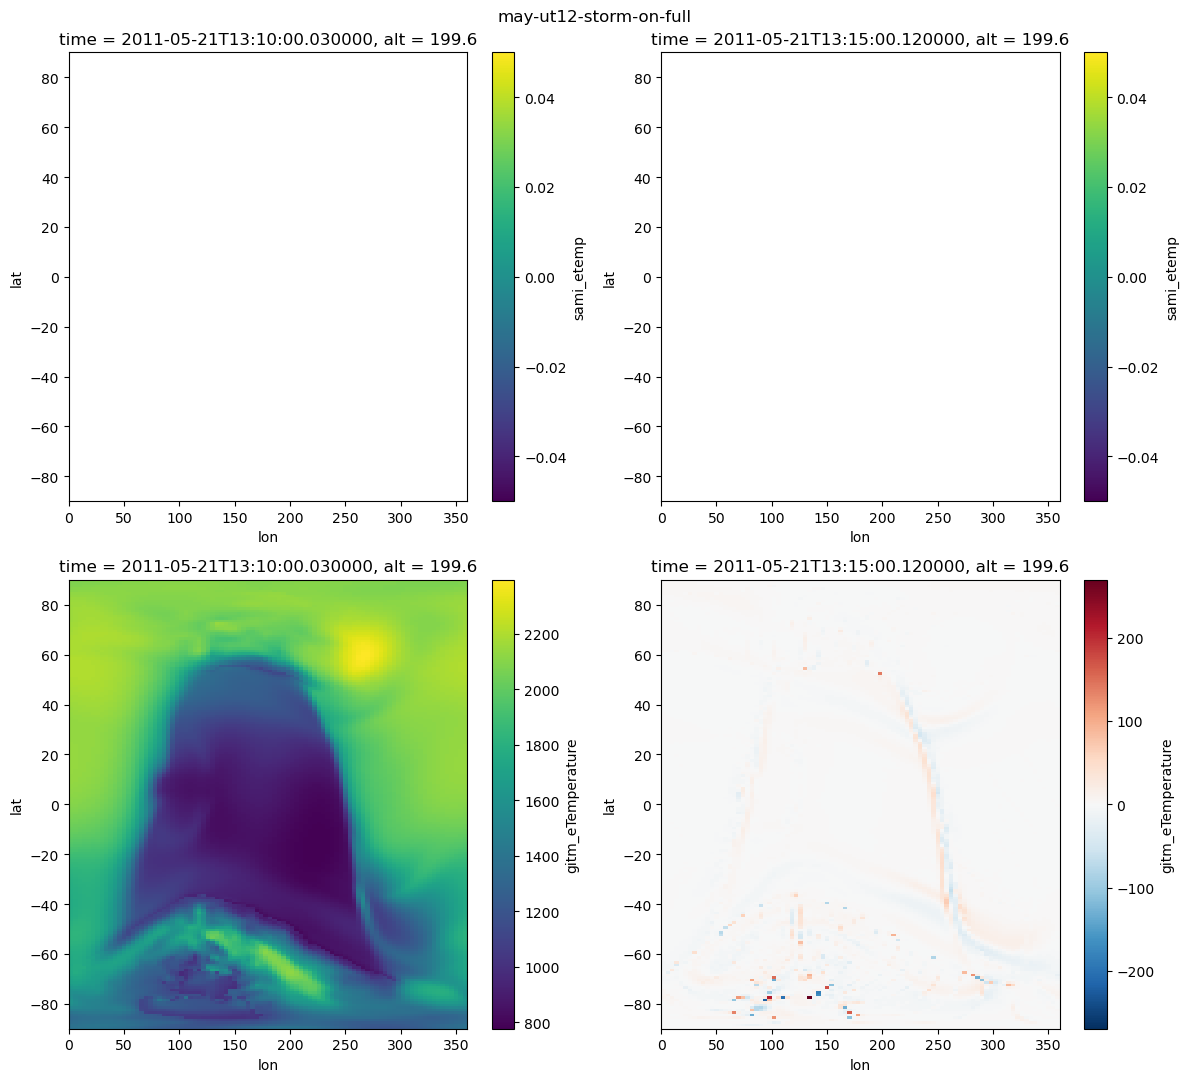

In [57]:
figs[0]